<a href="https://colab.research.google.com/github/PankajShukla/Stock-Market-Trend-Prediction/blob/main/Production_Trend_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM machine learning algorithm in Production

# Library installation

In [1]:
!pip install Keras

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import datetime
sns.set_style('whitegrid')

%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras import callbacks

from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_column", 500)

from google.colab import drive

import h5py

import panel as pn
pn.extension()

# Setting up Drive for pulling data

In [3]:
drive.mount('/content/drive', force_remount=True)
DrivePath = input('Enter Drive Path Location where the file is stored.')

Mounted at /content/drive
Enter Drive Path Location where the file is stored./content/drive/MyDrive/Data Scientist/Interview/Interview offline problem solving/Aditya Birla Group/


In [4]:
# /content/drive/MyDrive/Data Scientist/Interview/Interview offline problem solving/Aditya Birla Group/

# Loading the Dataset

In [5]:
cwdir = os.getcwd()
filename = 'Input_data.csv'
filename = os.path.join(DrivePath,filename)

In [6]:
def preprocess_data( data_years = [2024,2024] ):


  """
  -------------------------------------------------------
  Loading the data
  -------------------------------------------------------
  """

  df = pd.read_csv(filename)
  df.head(3)



  """
  -------------------------------------------------------
  Deriving fields and creating additional metrics
  -------------------------------------------------------
  """

  df['timestamp'] = pd.to_datetime(df['Date-Time'], format='%d/%m/%y %H:%M')

  df['date'] = df['timestamp'].dt.date

  df['dayofweek'] = df['timestamp'].dt.weekday
  df['dayofmonth'] = df['timestamp'].dt.day
  df['year'] = df['timestamp'].dt.year
  df['quarter'] = df['timestamp'].dt.quarter
  df['month'] = df['timestamp'].dt.month
  df['weekofyear'] = df['timestamp'].dt.isocalendar().week
  df['hour'] = df['timestamp'].dt.hour
  df['minute'] = df['timestamp'].dt.minute

  df['prev_Close'] = df['Close'].shift(1)
  df['prev_Close'].fillna(df['Close'], inplace=True)

  df['TR1'] = df['High']-df['Low']
  df['TR2'] = df['High']-df['prev_Close']
  df['TR3'] = df['Low'] -df['prev_Close']

  df['TR'] = df[['TR1','TR2','TR3']].max(axis=1)

  df['ATR'] = df['Close'].rolling(14, min_periods=1).mean()
  df['SMA_50'] = df['Close'].rolling(50, min_periods=1).mean()
  df['EMA_50'] = df['Close'].ewm(com=2).mean()



  """
  -------------------------------------------------------
  EDA
  -------------------------------------------------------
  """

  df_reading_cnt = df.groupby('date')['timestamp'].nunique().reset_index()
  df.drop(columns=['prev_Close', 'TR1', 'TR2', 'TR3'], inplace=True)

  """
  -------------------------------------------------------
  Selecting data size for entire exercise
  -------------------------------------------------------
  """

  org_df = df.copy(deep=True)

  df = df[ (df.year>=data_years[0]) & (df.year<=data_years[1])]
  print(df.year.value_counts().reset_index().sort_values('year'))
  print(df.Trend_final.value_counts())

  return df



# Scaling function

In [7]:
def variable_scaling( _df, features, output_var):

  #Scaling
  scaler = MinMaxScaler()
  feature_transform = scaler.fit_transform(_df[features])
  feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=_df.index)
  feature_transform.head()

  return feature_transform

# Classification report generating function

In [8]:
def generate_classification_report(_model, X_test, y_test ):
  testPredict = _model.predict(X_test)
  yPred = testPredict.ravel()

  yPred_ = []
  for v in yPred:
    if v>=0.5:
      yPred_.append(1)
    else:
      yPred_.append(0)

  print(classification_report(yPred_, y_test))
  return yPred_

# Main Block to call all functions

In [9]:

def main(DrivePath, _df, modelFile=None):

  filepath1 = os.path.join(DrivePath, 'model')

  if modelFile:
    print('Model file has been provided!')
    print(modelFile)

  else:
    print('Model file has not been provided! Looking for the latest model file in gdrive.')
    modelFileList = []
    for modelFile in os.listdir(filepath1):
        if modelFile.find('h5') > -1:
            modelFileList.append(modelFile)

    modelFileList = sorted(modelFileList)
    modelFile = modelFileList[-1]
    print(modelFile)



  """
  ------------------------------------------------------------
  Load data
  ------------------------------------------------------------
  """

  output_var = pd.DataFrame(_df['Trend_final'])
  features = ['Open', 'High', 'Low', 'Close', 'cci_50', 'Close_supertrend_diff', 'ATR_EMA_diff', 'Trend_initial']



  """
  ------------------------------------------------------------
  Load Stored Model
  ------------------------------------------------------------
  """
  LSTM_model = load_model(os.path.join(filepath1, modelFile))

  X_try_feature_transform = variable_scaling(_df, features, output_var)

  X_try = np.array(X_try_feature_transform).reshape(X_try_feature_transform.shape[0], 1, X_try_feature_transform.shape[1])
  y_try = pd.DataFrame(_df['Trend_final']).values.ravel()
  print(X_try.shape, y_try.shape)

  scores = LSTM_model.evaluate(X_try, y_try, verbose=1)
  print("Accuracy: %.2f%%" % (scores[1]*100))

  y_try_pred = generate_classification_report(LSTM_model, X_try, y_try)
  _df = pd.merge(_df, pd.DataFrame(y_try_pred, columns=['predicted_TrendFinal']), on=_df.index, how='left')

  return _df

# Profit Calculation

In [10]:
def Buy_Sell_trade_Label(_df, col_trend_initial, col_trend_final, col_final_trade_label):

  _df[col_trend_initial+'_trade_label'] = np.where(_df[col_trend_initial].shift(1) > _df[col_trend_initial].shift(2), 'buy',
                                                   np.where(_df[col_trend_initial].shift(1) < _df[col_trend_initial].shift(2),'sell',None))

  _df[col_trend_final+'_trade_label'] = np.where(_df[col_trend_final].shift(1) > _df[col_trend_final].shift(2), 'buy',
                                                   np.where(_df[col_trend_final].shift(1) < _df[col_trend_final].shift(2),'sell',None))

  _df[col_final_trade_label] = np.where(   (_df[col_trend_initial+'_trade_label']==_df[col_trend_final+'_trade_label'])
                                         & (_df[col_trend_initial+'_trade_label']=='buy'), 'buy',
                                      np.where(   (_df[col_trend_initial+'_trade_label']==_df[col_trend_final+'_trade_label'])
                                                & (_df[col_trend_initial+'_trade_label']=='sell'), 'sell', None))

  return _df



def Profit_Calculation(_df, col_final_trade_label, col_profit ):

  """
  ------------------------------------------------
  Imputation for adding first trade signal
  ------------------------------------------------
  """
  first_trade_signal = _df[_df[col_final_trade_label].notnull()][col_final_trade_label].unique()[0]
  first_trade_signal_index = _df[_df[col_final_trade_label].notnull()].index.min()

  print(first_trade_signal_index, first_trade_signal)

  if first_trade_signal == 'sell':
    first_trade_signal='buy'
  elif first_trade_signal == 'buy':
    first_trade_signal='sell'
  else:
    pass

  if first_trade_signal_index != 0:
    _df[col_final_trade_label] = np.where(_df.index==0, first_trade_signal, _df[col_final_trade_label])

  _df_profit = _df[_df[col_final_trade_label].notnull()]
  _df_profit[col_profit] = _df_profit['Open'] - _df_profit['Open'].shift(-1)
  _df = pd.concat([_df, _df_profit[col_profit]], axis=1)

  return _df



In [11]:
def chart_calculations(_df):

    _df['Close_TrendFinal'] = np.where(_df['Trend_final']==1, _df['Close']*(1-0.0003), np.nan)
    _df['Close_Precicted_TrendFinal'] = np.where(_df['predicted_TrendFinal']==1, _df['Close']*(1+0.0003), np.nan)

    _df = Buy_Sell_trade_Label(_df, col_trend_initial = 'Trend_initial', col_trend_final= 'Trend_final', col_final_trade_label = 'actual_final_trade_label')
    _df = Profit_Calculation(_df, col_final_trade_label = 'actual_final_trade_label', col_profit= 'actual_profit')

    _df = Buy_Sell_trade_Label(_df, col_trend_initial = 'Trend_initial', col_trend_final= 'predicted_TrendFinal', col_final_trade_label = 'predicted_final_trade_label')
    _df = Profit_Calculation(_df, col_final_trade_label = 'predicted_final_trade_label', col_profit= 'predicted_profit')

    _df['Actual_Buy']  = np.where(_df['actual_final_trade_label']=='buy',  _df['Close']*(1-0.0003), np.nan)
    _df['Actual_Sell'] = np.where(_df['actual_final_trade_label']=='sell', _df['Close']*(1-0.0003), np.nan)

    _df['Predicted_Buy'] = np.where(_df['predicted_final_trade_label']=='buy',  _df['Close']*(1+0.0003), np.nan)
    _df['Predicted_Sell'] = np.where(_df['predicted_final_trade_label']=='sell', _df['Close']*(1+0.0003), np.nan)

    print('Actual Profit :', _df.actual_profit.sum())
    print('Predicted Profit :', _df.predicted_profit.sum())

    return _df

# Run the script

In [12]:

if __name__ == "__main__":
    # Execute the main function if the script is run directly
    #  'stock_trend_lstm_2024-06-20_H17.h5'
    _df = preprocess_data([2024,2024])
    print(_df.shape)
    output_data = main(DrivePath, _df, 'stock_trend_lstm_2024-06-20_H17.h5')
    output_data = chart_calculations(output_data)

    print(output_data.groupby(['year','month'])[['actual_profit','predicted_profit']].sum().reset_index())

   year  count
0  2024   7350
Trend_final
0    5288
1    2062
Name: count, dtype: int64
(7350, 24)
Model file has been provided!
stock_trend_lstm_2024-06-20_H17.h5


(7350, 1, 8) (7350,)
230/230 [==============================] - 2s 2ms/step - loss: 0.2906 - accuracy: 0.8355
Accuracy: 83.55%
230/230 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      4169
           1       0.98      0.63      0.77      3181

    accuracy                           0.84      7350
   macro avg       0.88      0.81      0.82      7350
weighted avg       0.87      0.84      0.83      7350

72 buy
5 buy
Actual Profit : -1043.75
Predicted Profit : -799.9500000000007
   year  month  actual_profit  predicted_profit
0  2024      1        -180.25             30.85
1  2024      2        -480.00           -663.30
2  2024      3        -316.25           -152.40
3  2024      4          10.30           -181.35
4  2024      5         -77.55            166.25


In [15]:
print(output_data[['actual_profit','predicted_profit']].sum())

actual_profit      -1043.75
predicted_profit    -799.95
dtype: float64


# View the Stock Graph basis selected date

The below plot shows trend curve for a specific day - '2024-05-29'


*   Close (blue)
*   EMA50 (green)
*   upward trend positions - actual (red)
*   upward trend positions - predicted (purple)


In [13]:
timestamp = str(datetime.datetime.now())[:15].replace(' ','_H').replace(':','_M')
output_csv_filename = os.path.join(DrivePath, "output", 'trend_output_'+timestamp+'.csv')
print('storing csv in : ', output_csv_filename)
output_data.to_csv(output_csv_filename, index=False)

storing csv in :  /content/drive/MyDrive/Data Scientist/Interview/Interview offline problem solving/Aditya Birla Group/output/trend_output_2024-06-25_H13_M4.csv


In [14]:
date_picker = pn.widgets.DatePicker(name='Date Picker', value=output_data['date'].max(),)
pn.Column(date_picker, height=350)

Column(height=350)
    [0] DatePicker(name='Date Picker', value=datetime.date(2024, ...)

In [16]:
output_data.head(3)

,key_0,Date-Time,Open,High,Low,Close,cci_50,Close_supertrend_diff,ATR_EMA_diff,Trend_initial,Trend_final,timestamp,date,dayofweek,dayofmonth,year,quarter,month,weekofyear,hour,minute,TR,ATR,SMA_50,EMA_50,predicted_TrendFinal,Close_TrendFinal,Close_Precicted_TrendFinal,Trend_initial_trade_label,Trend_final_trade_label,actual_final_trade_label,actual_profit,predicted_TrendFinal_trade_label,predicted_final_trade_label,predicted_profit,Actual_Buy,Actual_Sell,Predicted_Buy,Predicted_Sell
0,239409,01/01/24 9:20,21727.7,21732.50,21693.75,21693.75,-98.24,0.0,2.87,0,0,2024-01-01 09:20:00,2024-01-01,0,1,2024,1,1,1,9,20,38.75,21717.053571,21723.377,21714.461482,0,NaN,NaN,None,None,sell,1.75,None,sell,39.7,NaN,21687.241875,NaN,21700.258125
1,239410,01/01/24 9:25,21693.9,21701.05,21685.50,21695.65,-159.44,0.0,2.45,0,0,2024-01-01 09:25:00,2024-01-01,0,1,2024,1,1,1,9,25,15.55,21717.446429,21722.680,21708.190988,0,NaN,NaN,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN
2,239411,01/01/24 9:30,21697.3,21704.10,21693.20,21700.80,-124.09,0.0,1.66,0,0,2024-01-01 09:30:00,2024-01-01,0,1,2024,1,1,1,9,30,10.90,21716.942857,21721.930,21705.727325,0,NaN,NaN,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN


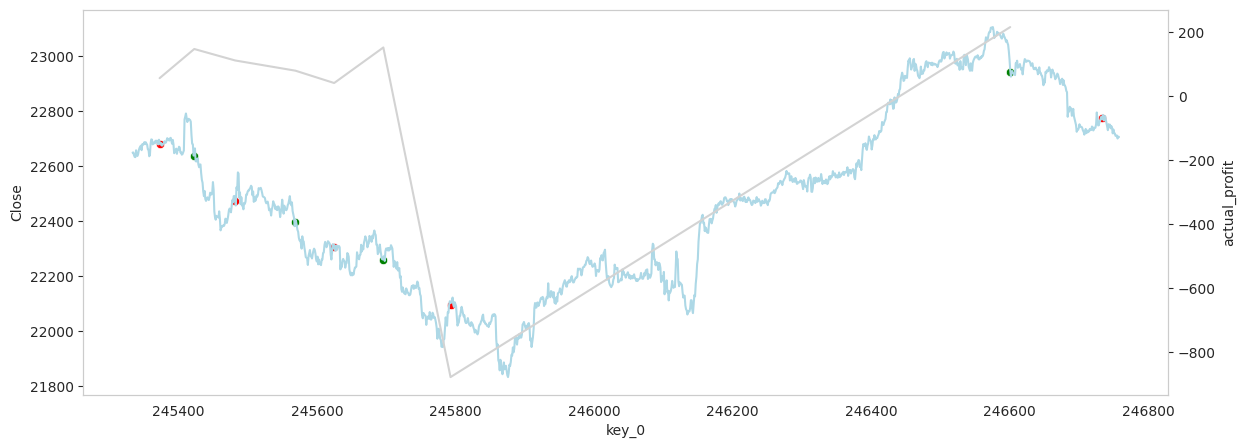

In [17]:
# data = output_data[output_data['date'] == date_picker.value]

data = output_data[output_data['date'].astype('datetime64[ns]').between('2024-05-01','2024-05-31')]

fig, ax1 = plt.subplots(1,1, figsize = (14,5))
sns.lineplot(data=data, x='key_0', y='Close', ax=ax1, color='lightblue')
# sns.lineplot(data=data, x='key_0', y='EMA50', ax=ax1, color='lightgreen')

sns.scatterplot(data=data, x='key_0', y='Actual_Buy' , ax=ax1, color='green')
sns.scatterplot(data=data, x='key_0', y='Actual_Sell', ax=ax1, color='red')

ax2 = ax1.twinx()

sns.lineplot(data=data, x='key_0', y='actual_profit', ax=ax2, color = 'lightgrey')

ax1.grid(False)
ax2.grid(False)
plt.show()

In [18]:
output_data.head(3)

,key_0,Date-Time,Open,High,Low,Close,cci_50,Close_supertrend_diff,ATR_EMA_diff,Trend_initial,Trend_final,timestamp,date,dayofweek,dayofmonth,year,quarter,month,weekofyear,hour,minute,TR,ATR,SMA_50,EMA_50,predicted_TrendFinal,Close_TrendFinal,Close_Precicted_TrendFinal,Trend_initial_trade_label,Trend_final_trade_label,actual_final_trade_label,actual_profit,predicted_TrendFinal_trade_label,predicted_final_trade_label,predicted_profit,Actual_Buy,Actual_Sell,Predicted_Buy,Predicted_Sell
0,239409,01/01/24 9:20,21727.7,21732.50,21693.75,21693.75,-98.24,0.0,2.87,0,0,2024-01-01 09:20:00,2024-01-01,0,1,2024,1,1,1,9,20,38.75,21717.053571,21723.377,21714.461482,0,NaN,NaN,None,None,sell,1.75,None,sell,39.7,NaN,21687.241875,NaN,21700.258125
1,239410,01/01/24 9:25,21693.9,21701.05,21685.50,21695.65,-159.44,0.0,2.45,0,0,2024-01-01 09:25:00,2024-01-01,0,1,2024,1,1,1,9,25,15.55,21717.446429,21722.680,21708.190988,0,NaN,NaN,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN
2,239411,01/01/24 9:30,21697.3,21704.10,21693.20,21700.80,-124.09,0.0,1.66,0,0,2024-01-01 09:30:00,2024-01-01,0,1,2024,1,1,1,9,30,10.90,21716.942857,21721.930,21705.727325,0,NaN,NaN,None,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN


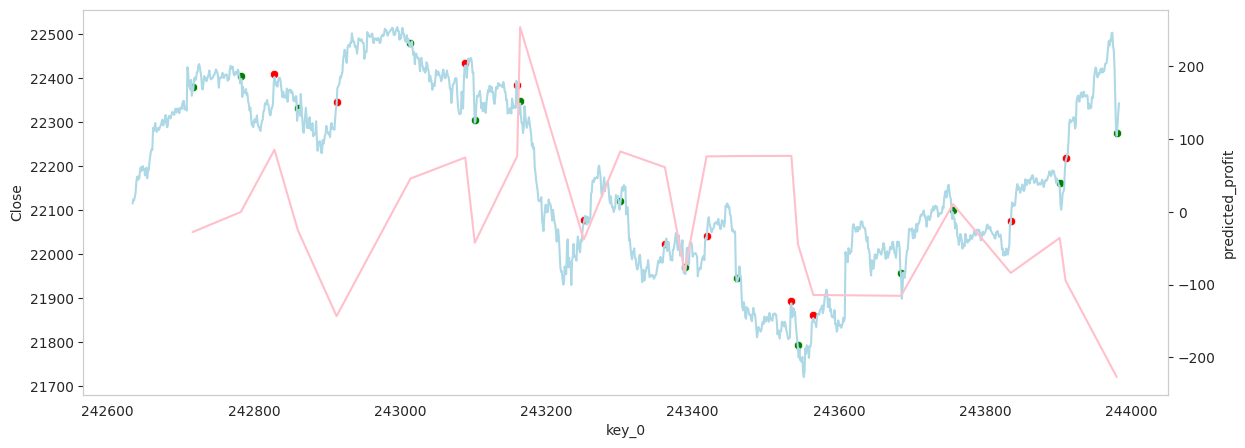

In [20]:
# data = output_data[output_data['date'] == date_picker.value]

data = output_data[output_data['date'].astype('datetime64[ns]').between('2024-03-01','2024-03-31')]

fig, ax1 = plt.subplots(1,1, figsize = (14,5))
sns.lineplot(data=data, x='key_0', y='Close', ax=ax1, color='lightblue')

sns.scatterplot(data=data, x='key_0', y='Predicted_Buy' , ax=ax1, color='green')
sns.scatterplot(data=data, x='key_0', y='Predicted_Sell', ax=ax1, color='red')

ax2 = ax1.twinx()

sns.lineplot(data=data, x='key_0', y='predicted_profit', ax=ax2, color = 'pink')

ax1.grid(False)
ax2.grid(False)

plt.show()

# Code Ends